In [2]:
import glob
from PIL import Image
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import tensorflow as tf
import read_data
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import cv2
# load model and visualize result

c:\Users\drago\anaconda3\envs\iot\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\drago\anaconda3\envs\iot\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\drago\anaconda3\envs\iot\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\drago\anaconda3\envs\iot\lib\site-packages\tensorflow\python\framework

len files :  69622
(100, 150, 3)
(90, 60)


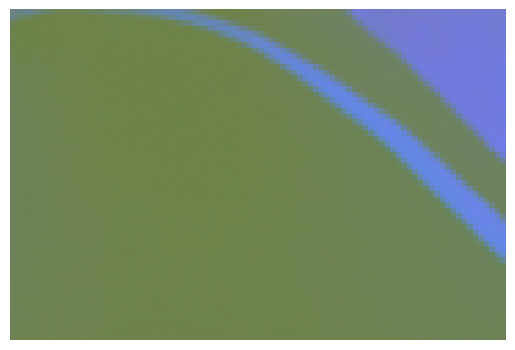

In [3]:
file_path = []

folder = glob.glob('data/*')
for f in folder:
    file_path += glob.glob(str(f) + "/*")
    
print("len files : " , len(file_path))


sample = Image.open(file_path[1222])

print(np.array(sample).shape)

plt.imshow(sample)
plt.axis('off')
plt.imshow(sample.resize((90,60)))
print(sample.resize((90,60)).size)


In [14]:
import glob
from PIL import Image
import numpy as np
import random
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
import matplotlib.pyplot as plt
label_list =[0, 45, 90, 135, 180]

def get_label_from_filename(filename):
    cvurrnet_label = re.findall(r'\d+', filename)[-1]  # 파일명에서 숫자 부분 추출
    for i,label in enumerate(label_list):
        if label == int(cvurrnet_label):
            return int(i)
        # else:
        #     print("dont have label", int(cvurrnet_label))
    return int(100)

class DataReader:
    def __init__(self):
        self.x_train = []
        self.x_test = []
        self.y_train = []
        self.y_test = []
        
        self.target = []
        
    def f_data_reader(self, img_size = (0,0), batch_size = 32):
        file_path = []
        folder = glob.glob('data/*')
        for f in folder:
            file_path += glob.glob(str(f) + "/*")

        print("len files : " , len(file_path))
        
        data = []
        for i, path in enumerate(file_path):
            img = Image.open(path)
            
            if img_size[0] != 0 :
                img = img.resize((img_size[0], img_size[1]))
                
            img = np.asarray(img)
            label = get_label_from_filename(path)
            if i % 10 == 0:  # Add the image only once every 10 images
                data.append((img, label))

            if i % 5000 == 0:
                print("processed : {} / {}".format(i,len(file_path)) )
       
        random.shuffle(data)

        target = [row[1] for row in data]
        self.target = target
        data = [row[0] for row in data]
        num_label = len(np.unique(target))
        print(np.unique(target))
        print("num class : ", num_label)
        #one hot
        #stf.keras.utils.to_categorical(target, num_label)
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
        data, target, test_size=0.2, shuffle=True, stratify=target, random_state=34)
        self.x_train = np.array(self.x_train) / 255.0
        self.x_test = np.array(self.x_test) / 255.0
        self.y_train = np.array(self.y_train) / 1.0
        self.y_test = np.array(self.y_test) / 1.0

        print("\n\nData Read Done!")
        print("Training X Size : " + str(self.x_train.shape))
        print("Training Y Size : " + str(self.y_train.shape))
        print("Test X Size : " + str(self.x_test.shape))
        print("Test Y Size : " + str(self.y_test.shape) + '\n\n')

        # target 리스트에 저장된 값들의 분포 그래프 그리기
        plt.hist(target)
        plt.title("Distribution of Target Values")
        plt.xlabel("Target Values")
        plt.ylabel("Frequency")
        plt.show()

In [15]:
import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizers import Adam
import os

test = DataReader()
test.f_data_reader((128,128))
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape = (128,128,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2000, activation=tf.nn.relu),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])
model.compile(optimizer=Adam(lr=0.001), metrics=['accuracy'], loss='sparse_categorical_crossentropy')
print("model defined\n\n", model.summary())

print("\n\n************ TRAINING START ************")
early_stop = EarlyStopping(monitor='val_loss', patience=4)
early_stop2 = EarlyStopping(monitor='val_acc', patience=4)
print(test.y_train.dtype)

history = model.fit(test.x_train, test.y_train, epochs=30, batch_size=32,
                    validation_data=(test.x_test, test.y_test),
                    callbacks=[early_stop, early_stop2])


res = model.evaluate(test.x_test, test.y_test, verbose=0)
print("acc is: ", res[1] * 100)

model.save('./trained_models/0529_30_epochs.h5')

len files :  69622
processed : 0 / 69622
processed : 5000 / 69622
processed : 10000 / 69622
processed : 15000 / 69622
processed : 20000 / 69622
